### Imports

In [502]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [503]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


### Read data

In [504]:
host= "18.136.157.135"
user= "dm_team"
password= "DM!$Team@&27920!"
database= "project_itsm"

connection = pymysql.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

pd.read_sql("show tables", connection)

data = pd.read_sql("select * from dataset_list", connection)

data = pd.read_csv('incident.csv')

In [505]:
data.columns = data.columns.str.lower()

In [506]:
data.columns

Index(['ci_name', 'ci_cat', 'ci_subcat', 'wbs', 'incident_id', 'status',
       'impact', 'urgency', 'priority', 'number_cnt', 'category', 'kb_number',
       'alert_status', 'no_of_reassignments', 'open_time', 'reopen_time',
       'resolved_time', 'close_time', 'handle_time_hrs', 'closure_code',
       'no_of_related_interactions', 'related_interaction',
       'no_of_related_incidents', 'no_of_related_changes', 'related_change'],
      dtype='object')

* WBS stands for Work Breakdown Structure.WBS is a project management tool used to break down a large project into smaller, more manageable components or tasks.
* kb_number typically refers to a Knowledge Base (KB) article number

* Group incidents by project component. Analyze which areas generate the most incidents
* Check how many incidents were resolved using KBs. Track which KBs are most useful

### EDA 1

In [507]:
pd.set_option('display.max_columns', None)

In [508]:
data.head(5)

,ci_name,ci_cat,ci_subcat,wbs,incident_id,status,impact,urgency,priority,number_cnt,category,kb_number,alert_status,no_of_reassignments,open_time,reopen_time,resolved_time,close_time,handle_time_hrs,closure_code,no_of_related_interactions,related_interaction,no_of_related_incidents,no_of_related_changes,related_change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,,
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,,
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,,,
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,,,
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,,,


In [509]:
data['no_of_reassignments'].value_counts().sort_values(ascending=False)

no_of_reassignments
0     27468
1      7268
2      5378
3      2191
4      1606
5       721
6       622
7       329
8       246
9       170
10      146
11      101
13       61
12       58
14       47
15       43
17       27
16       25
18       14
21       11
22       10
19       10
25       10
26        7
20        7
23        5
33        3
24        3
32        3
30        3
27        2
38        1
37        1
42        1
39        1
46        1
31        1
45        1
34        1
29        1
          1
36        1
Name: count, dtype: int64

In [510]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ci_name                     46606 non-null  object
 1   ci_cat                      46606 non-null  object
 2   ci_subcat                   46606 non-null  object
 3   wbs                         46606 non-null  object
 4   incident_id                 46606 non-null  object
 5   status                      46606 non-null  object
 6   impact                      46606 non-null  object
 7   urgency                     46606 non-null  object
 8   priority                    46606 non-null  object
 9   number_cnt                  46606 non-null  object
 10  category                    46606 non-null  object
 11  kb_number                   46606 non-null  object
 12  alert_status                46606 non-null  object
 13  no_of_reassignments         46606 non-null  ob

In [511]:
data.ci_cat.unique()

array(['subapplication', 'application', 'computer', '', 'displaydevice',
       'software', 'storage', 'database', 'hardware', 'officeelectronics',
       'networkcomponents', 'applicationcomponent', 'Phone'], dtype=object)

In [512]:
data.category.unique()

array(['incident', 'request for information', 'complaint',
       'request for change'], dtype=object)

In [513]:
data.isna().sum()

ci_name                       0
ci_cat                        0
ci_subcat                     0
wbs                           0
incident_id                   0
status                        0
impact                        0
urgency                       0
priority                      0
number_cnt                    0
category                      0
kb_number                     0
alert_status                  0
no_of_reassignments           0
open_time                     0
reopen_time                   0
resolved_time                 0
close_time                    0
handle_time_hrs               0
closure_code                  0
no_of_related_interactions    0
related_interaction           0
no_of_related_incidents       0
no_of_related_changes         0
related_change                0
dtype: int64

In [514]:
data.shape

(46606, 25)

In [515]:
for col in data.columns:
    print(col, "--", data[col].nunique(), "--", data[col].unique())

ci_name -- 3019 -- ['SUB000508' 'WBA000124' 'DTA000024' ... 'CBD000595' 'CBD000443'
 'SWT000008']
ci_cat -- 13 -- ['subapplication' 'application' 'computer' '' 'displaydevice' 'software'
 'storage' 'database' 'hardware' 'officeelectronics' 'networkcomponents'
 'applicationcomponent' 'Phone']
ci_subcat -- 65 -- ['Web Based Application' 'Desktop Application' 'Server Based Application'
 'SAP' 'Client Based Application' 'Citrix' 'Standard Application'
 'Windows Server' 'Laptop' 'Linux Server' '' 'Monitor'
 'Automation Software' 'SAN' 'Banking Device' 'Desktop' 'Database'
 'Oracle Server' 'Keyboard' 'Printer' 'Exchange' 'System Software' 'VDI'
 'Encryption' 'Omgeving' 'MigratieDummy' 'Scanner' 'Controller'
 'DataCenterEquipment' 'KVM Switches' 'Switch' 'Database Software'
 'Network Component' 'Unix Server' 'Lines' 'ESX Cluster' 'zOS Server'
 'SharePoint Farm' 'NonStop Server' 'Application Server'
 'Security Software' 'Thin Client' 'zOS Cluster' 'Router' 'VMWare'
 'Net Device' 'Neoview Serve

### EDA notes
1. No null values as per isna()
2. all columns are object types
3. related_interaction - Not interested in interaction ID. Drop it.
4. no_of_related_incidents	no_of_related_changes	related_change - Most values are empty. droping it.
5. reopen_time - 95% data is empty. droping it
6. alert_status - value is same for all rows. droping it
7. incident_id - unique for each row. Dropin it
8. Null values are represented as :
   * '' - ci_cat, ci_subcat, no_of_reassignments
   * 'NS' (Not Specified/ Not Set) - impact, 
   * 'unknown' - closure_code
   * '5 - Very Low' - urgency
   * 'NA' - priority

### Preprocessing

#### Drop cols

In [516]:
data.drop(['related_interaction', 'no_of_related_incidents','no_of_related_changes','related_change','reopen_time', 'alert_status','incident_id'], axis=1, inplace=True)

#### Null values fixes

##### ci_cat & ci_subcat

* 111 columns have both these values as ''
* if one is empty, other is always empty. Other ways is not seen in this dataset
* Replacing ci_cat with mode (application) and ci_subcat with mode of application (Server Based Application)

In [517]:
print(data['ci_cat'].unique())
print(data['ci_subcat'].unique())

['subapplication' 'application' 'computer' '' 'displaydevice' 'software'
 'storage' 'database' 'hardware' 'officeelectronics' 'networkcomponents'
 'applicationcomponent' 'Phone']
['Web Based Application' 'Desktop Application' 'Server Based Application'
 'SAP' 'Client Based Application' 'Citrix' 'Standard Application'
 'Windows Server' 'Laptop' 'Linux Server' '' 'Monitor'
 'Automation Software' 'SAN' 'Banking Device' 'Desktop' 'Database'
 'Oracle Server' 'Keyboard' 'Printer' 'Exchange' 'System Software' 'VDI'
 'Encryption' 'Omgeving' 'MigratieDummy' 'Scanner' 'Controller'
 'DataCenterEquipment' 'KVM Switches' 'Switch' 'Database Software'
 'Network Component' 'Unix Server' 'Lines' 'ESX Cluster' 'zOS Server'
 'SharePoint Farm' 'NonStop Server' 'Application Server'
 'Security Software' 'Thin Client' 'zOS Cluster' 'Router' 'VMWare'
 'Net Device' 'Neoview Server' 'MQ Queue Manager' 'UPS' 'Number'
 'Iptelephony' 'Windows Server in extern beheer' 'Modem' 'X86 Server'
 'ESX Server' 'Virtual Tap

In [518]:
data[(data['ci_cat'].str.strip() == '') & (data['ci_subcat'].str.strip() == '')].shape

(111, 18)

In [519]:
data[(data['ci_cat'].str.strip() == '') & (data['ci_subcat'].str.strip() != '')].shape

(0, 18)

In [520]:
data[(data['ci_cat'].str.strip() != '') & (data['ci_subcat'].str.strip() == '')].shape

(0, 18)

In [521]:
data.ci_cat.value_counts()

ci_cat
application             32900
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
                          111
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: count, dtype: int64

In [522]:
data[data['ci_cat'] == 'application'].ci_subcat.value_counts()

ci_subcat
Server Based Application    17478
Web Based Application        9022
Desktop Application          3876
SAP                          1199
Citrix                        634
Client Based Application      486
Exchange                      130
Standard Application           63
SharePoint Farm                11
VMWare                          1
Name: count, dtype: int64

In [523]:
data.loc[data['ci_cat'].str.strip() == '',['ci_cat']] = 'application'

In [524]:
data.loc[data['ci_subcat'].str.strip() == '',['ci_subcat']] = 'Server Based Application'

In [525]:
data['ci_cat'].mode()

0    application
Name: ci_cat, dtype: object

##### no_of_reassignments

In [526]:
data['no_of_reassignments'] = pd.to_numeric(data['no_of_reassignments'].replace('', '0'))

In [527]:
data['no_of_reassignments'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 46606 entries, 0 to 46605
Series name: no_of_reassignments
Non-Null Count  Dtype
--------------  -----
46606 non-null  int64
dtypes: int64(1)
memory usage: 364.2 KB


In [528]:
data['impact'].value_counts()

impact
4     22556
5     16741
3      5234
NS     1380
2       692
1         3
Name: count, dtype: int64

#####  no_of_related_interactions

In [529]:
data['no_of_related_interactions'] = pd.to_numeric(data['no_of_related_interactions'].replace('',0))

In [530]:
data['no_of_related_interactions'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 46606 entries, 0 to 46605
Series name: no_of_related_interactions
Non-Null Count  Dtype
--------------  -----
46606 non-null  int64
dtypes: int64(1)
memory usage: 364.2 KB


##### impact, urgency & priority
* impact, urgency and priority are corelated
* 1380 rows have both impact and priority as Null.
* For most of the records all 3 values are same
* Imputing Null as the value of urgent, since urgent dosent have null
* replacing '5 - Very Low' with 5 in urgency col

In [531]:
print(data[data['impact']=='NS'].shape)

print(data[data['urgency']=='5 - Very Low'].shape)

print(data[data['priority'] == 'NA'].shape)

print(data[(data['impact'] == 'NS') & (data['priority'] == 'NA')].shape)

(1380, 18)
(1, 18)
(1380, 18)
(1380, 18)


In [532]:
data.columns

Index(['ci_name', 'ci_cat', 'ci_subcat', 'wbs', 'status', 'impact', 'urgency',
       'priority', 'number_cnt', 'category', 'kb_number',
       'no_of_reassignments', 'open_time', 'resolved_time', 'close_time',
       'handle_time_hrs', 'closure_code', 'no_of_related_interactions'],
      dtype='object')

In [533]:
data['urgency'].unique()

array(['4', '3', '5', '2', '1', '5 - Very Low'], dtype=object)

In [534]:
data['urgency'].replace('5 - Very Low','5', inplace=True)

In [535]:
data['urgency'].value_counts()

urgency
4    22588
5    16780
3     6536
2      696
1        6
Name: count, dtype: int64

In [536]:
data['impact'].unique()

array(['4', '3', 'NS', '5', '2', '1'], dtype=object)

In [537]:
data.loc[(data['impact'] == 'NS'), 'impact'] = data.loc[(data['impact'] == 'NS'), 'urgency'] 

In [538]:
data.loc[(data['priority'] == 'NA'), 'priority'] = data.loc[(data['priority'] == 'NA'), 'urgency'] 

In [539]:
print(data['impact'].unique())
print(data['priority'].unique())

['4' '3' '5' '2' '1']
['4' '3' '5' '2' '1']


##### closure_code


In [540]:
data['closure_code'].value_counts()

closure_code
Other                           16470
Software                        13027
User error                       3554
No error - works as designed     3530
Hardware                         2999
Data                             2209
Unknown                          1590
Operator error                   1539
User manual not used              765
                                  460
Inquiry                           162
Referred                          158
Questions                         132
Kwaliteit van de output            10
Overig                              1
Name: count, dtype: int64

In [541]:
data['closure_code'].replace('', 'Unknown', inplace=True)

In [542]:
data.head(3)

,ci_name,ci_cat,ci_subcat,wbs,status,impact,urgency,priority,number_cnt,category,kb_number,no_of_reassignments,open_time,resolved_time,close_time,handle_time_hrs,closure_code,no_of_related_interactions
0,SUB000508,subapplication,Web Based Application,WBS000162,Closed,4,4,4,0.601292279,incident,KM0000553,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1
1,WBA000124,application,Web Based Application,WBS000088,Closed,3,3,3,0.415049969,incident,KM0000611,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1
2,DTA000024,application,Desktop Application,WBS000092,Closed,3,3,3,0.517551335,request for information,KM0000339,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1


In [543]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ci_name                     46606 non-null  object
 1   ci_cat                      46606 non-null  object
 2   ci_subcat                   46606 non-null  object
 3   wbs                         46606 non-null  object
 4   status                      46606 non-null  object
 5   impact                      46606 non-null  object
 6   urgency                     46606 non-null  object
 7   priority                    46606 non-null  object
 8   number_cnt                  46606 non-null  object
 9   category                    46606 non-null  object
 10  kb_number                   46606 non-null  object
 11  no_of_reassignments         46606 non-null  int64 
 12  open_time                   46606 non-null  object
 13  resolved_time               46606 non-null  ob

In [544]:
data['number_cnt'] = data['number_cnt'].astype(float)

In [545]:
data['open_time'] = pd.to_datetime(data['open_time'], format="%d-%m-%Y %H:%M")

In [546]:
data['resolved_time'] = pd.to_datetime(data['resolved_time'], format="%d-%m-%Y %H:%M")

In [547]:
data['close_time'] = pd.to_datetime(data['close_time'], format="%d-%m-%Y %H:%M")

In [548]:
 (data['close_time'] - data['open_time']).dt.total_seconds()/3600

0        15312.316667
1        15116.866667
2        15722.616667
3        11637.700000
4        10922.900000
             ...     
46601        0.100000
46602        0.433333
46603        0.066667
46604        0.116667
46605        5.383333
Length: 46606, dtype: float64

In [549]:
data['handle_time_hrs'] = data['handle_time_hrs'].str.replace(',', '', regex=False).sort_values(ascending=False)

In [550]:
data.loc[data['handle_time_hrs'] == '','handle_time_hrs'] =  (data['close_time'] - data['open_time']).dt.total_seconds()/3600

In [551]:
data['handle_time_hrs'] = pd.to_numeric(data['handle_time_hrs'])

In [552]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ci_name                     46606 non-null  object        
 1   ci_cat                      46606 non-null  object        
 2   ci_subcat                   46606 non-null  object        
 3   wbs                         46606 non-null  object        
 4   status                      46606 non-null  object        
 5   impact                      46606 non-null  object        
 6   urgency                     46606 non-null  object        
 7   priority                    46606 non-null  object        
 8   number_cnt                  46606 non-null  float64       
 9   category                    46606 non-null  object        
 10  kb_number                   46606 non-null  object        
 11  no_of_reassignments         46606 non-null  int64     

### EDA 2

In [553]:
data.describe(include=['int','float'])

,number_cnt,no_of_reassignments,handle_time_hrs,no_of_related_interactions
count,46606.000000,46606.000000,4.660600e+04,46606.000000
mean,0.499658,1.131807,2.399255e+09,1.147084
std,0.288634,2.269756,2.458997e+09,2.553841
min,0.000023,0.000000,0.000000e+00,0.000000
25%,0.248213,0.000000,4.313889e+08,1.000000
50%,0.500269,0.000000,1.583611e+09,1.000000
75%,0.749094,2.000000,3.583056e+09,1.000000
max,0.999997,46.000000,9.999722e+09,370.000000


In [554]:
data.describe(include="O")

,ci_name,ci_cat,ci_subcat,wbs,status,impact,urgency,priority,category,kb_number,closure_code
count,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606
unique,3019,12,64,274,2,5,5,5,4,1825,14
top,SUB000456,application,Server Based Application,WBS000073,Closed,4,4,4,incident,KM0001106,Other
freq,3050,33011,18922,13342,46597,22588,22588,22749,37748,1106,16470


In [555]:
a = data['ci_cat']+"_"+ data['ci_subcat']

In [556]:
a = np.unique(a)

In [557]:
len(a)

71

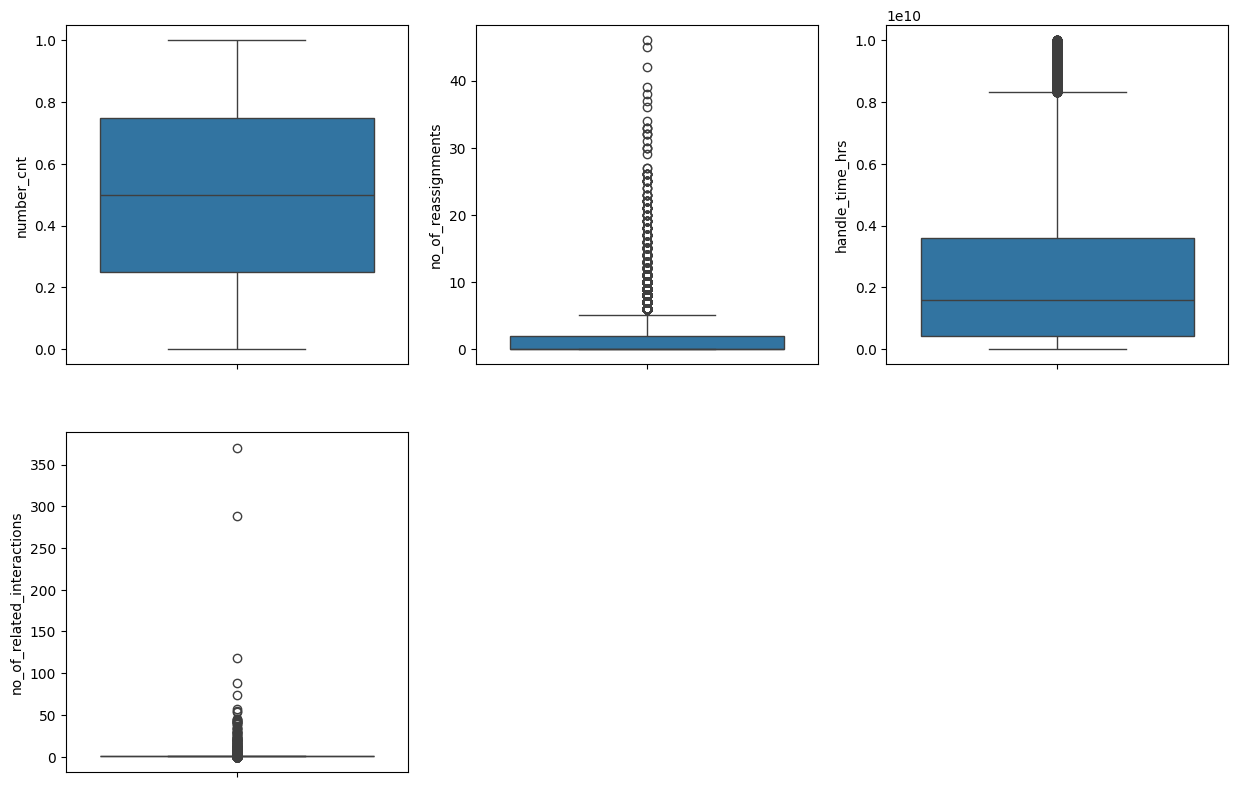

<Figure size 640x480 with 0 Axes>

In [558]:
plt.figure(figsize=(15,15))
for i, col in enumerate(data.select_dtypes(include=['int','float']).columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(data[col])
plt.show();
plt.tight_layout()

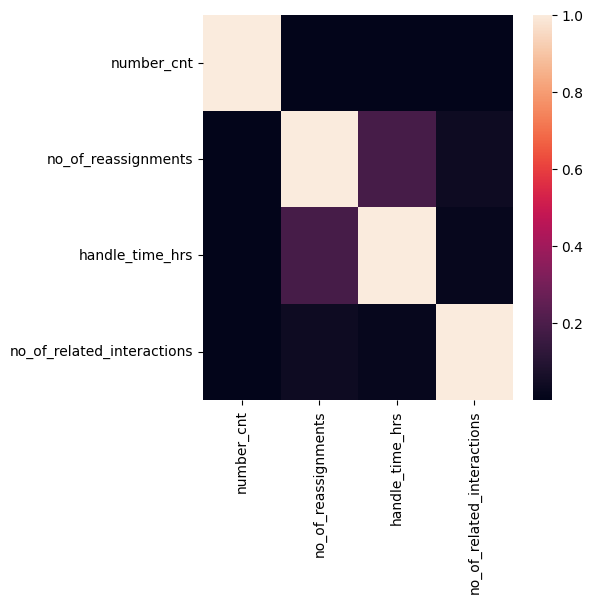

In [559]:
plt.figure(figsize=(5,5))
sns.heatmap(data.select_dtypes(include=['int','float']).corr().abs())
plt.show();

In [560]:
data.nunique() 

ci_name                        3019
ci_cat                           12
ci_subcat                        64
wbs                             274
status                            2
impact                            5
urgency                           5
priority                          5
number_cnt                    46606
category                          4
kb_number                      1825
no_of_reassignments              41
open_time                     34636
resolved_time                 33627
close_time                    34528
handle_time_hrs               30407
closure_code                     14
no_of_related_interactions       50
dtype: int64

In [561]:
data.head()

,ci_name,ci_cat,ci_subcat,wbs,status,impact,urgency,priority,number_cnt,category,kb_number,no_of_reassignments,open_time,resolved_time,close_time,handle_time_hrs,closure_code,no_of_related_interactions
0,SUB000508,subapplication,Web Based Application,WBS000162,Closed,4,4,4,0.601292,incident,KM0000553,26,2012-02-05 13:32:00,2013-11-04 13:50:00,2013-11-04 13:51:00,3.871691e+09,Other,1
1,WBA000124,application,Web Based Application,WBS000088,Closed,3,3,3,0.415050,incident,KM0000611,33,2012-03-12 15:44:00,2013-12-02 12:36:00,2013-12-02 12:36:00,4.354786e+09,Software,1
2,DTA000024,application,Desktop Application,WBS000092,Closed,3,3,3,0.517551,request for information,KM0000339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,4.843119e+09,No error - works as designed,1
3,WBA000124,application,Web Based Application,WBS000088,Closed,4,4,4,0.642927,incident,KM0000611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,4.321833e+09,Operator error,1
4,WBA000124,application,Web Based Application,WBS000088,Closed,4,4,4,0.345258,incident,KM0000611,2,2012-08-10 11:01:00,2013-11-08 13:55:00,2013-11-08 13:55:00,3.383903e+09,Other,1


In [562]:
data.isna().sum()

ci_name                          0
ci_cat                           0
ci_subcat                        0
wbs                              0
status                           0
impact                           0
urgency                          0
priority                         0
number_cnt                       0
category                         0
kb_number                        0
no_of_reassignments              0
open_time                        0
resolved_time                 1780
close_time                       0
handle_time_hrs                  0
closure_code                     0
no_of_related_interactions       0
dtype: int64

### EDA Notes :
* describe :
    2. Create new  col - cat_subcat - concating cat with subcat, and then apply freq enc or one-hot enc
    3. Freq enc high dimentional cat cols - ci_name, kb_number, wbs
    4. drop kb_number
* boxplot :
  1. No. of reassignments is too high. These may suggest some tickets that were too tricky to handle. Not handling the outliers.
  2. Handle time hours is too high for few tickets. We can  drop the entire column and calculate handle time using open time and close time; or fix outliers
* Heatmap :
   1. impact, urgency and priority are highly colinear. can drop 2 of them, likely impact and urgency.
 
* isna() :
  1. 1780 NaT for resolved time. setting resolved_time = close_time for missing values

     

### Preprocessing 2

Further preprocessing depends on the ML task.
1. Predicting High Priority Tickets: To predict priority 1 & 2 tickets, so that they can take preventive measures or fix the problem before it surfaces.
    * For this task create cat-subcat col
    * drop ci_name, incident_id

#### Outliers

Droping column handle_time_hrs, calculating it fresh using close time and open time

In [563]:
data.drop('handle_time_hrs', inplace=True, axis=1)

In [564]:
data['handle_time_hrs'] = (data['close_time'] - data['open_time']).dt.total_seconds()/3600

#### Drop impact, urgency

In [565]:
data.drop(['impact','urgency'], axis=1, inplace=True, errors='ignore')

In [566]:
data.columns

Index(['ci_name', 'ci_cat', 'ci_subcat', 'wbs', 'status', 'priority',
       'number_cnt', 'category', 'kb_number', 'no_of_reassignments',
       'open_time', 'resolved_time', 'close_time', 'closure_code',
       'no_of_related_interactions', 'handle_time_hrs'],
      dtype='object')

#### New col cat_sub_cat

In [567]:
data['cat-subcat'] = data['ci_cat']+"--"+data['ci_subcat']

#### resolved_time 

In [568]:
data.loc[data['resolved_time'].isna(),'resolved_time'] = data.loc[data['resolved_time'].isna(),'close_time']

# Writing data to local file. Delete later

In [569]:
data.to_pickle('data.pkl')

### Note

Further preprocessing will be done based on the ML algorithm used.
1. CatBoost 
2. LightGBM - Supports categorical data via integer encoding + categorical_feature argument.
3. XGBoost

above models can handle categorical columns. Encoding is minimal for these models

For other models we need to apply, one-hot, ordinal or frequency encoding

## Task1
Predicting High Priority Tickets: To predict priority 1 & 2 tickets, so that they can take preventive measures or fix the problem before it surfaces.

### CatBoost model

In [570]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

priority_enc = LabelEncoder()
y = priority_enc.fit_transform(data.priority)
x = data.drop('priority', axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [571]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [572]:
cat_features = x.select_dtypes(include='object').columns.tolist()

In [573]:
from collections import Counter

In [574]:
Counter(y_train)

Counter({3: 17112, 4: 12380, 2: 4935, 1: 525, 0: 2})

In [575]:
class_counts = [2,523,5003,17062,12364]
total = sum(class_counts)
class_weights = [total / c for c in class_counts] 

In [576]:
cat_params = {
    'iterations' : [1300, 1600],
    'depth' : [6,10,20],
    'l2_leaf_reg' : [1, 3, 5],
    'border_count' : [32, 64]
}

In [577]:
cat_grid = GridSearchCV(CatBoostClassifier(loss_function='MultiClass',
                                          cat_features=cat_features,
                                          task_type='GPU',
                                          class_weights=class_weights,
                                          eval_metric='MultiClass'), 
                       param_grid=cat_params, cv=4, scoring="f1_weighted", n_jobs=1, verbose=1)

cat_grid.fit(x_train, y_train)


```
cat_grid_train_pred = cat_grid.predict(x_train)
cat_grid_test_pred = cat_grid.predict(x_test)


print(f1_score(y_train, cat_grid_train_pred, average='weighted'))
print(f1_score(y_test, cat_grid_test_pred, average='weighted'))

cat_grid.best_params_
```

{'border_count': 64, 'depth': 10, 'iterations': 1600, 'l2_leaf_reg': 1}

In [578]:
cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.5,
    depth=7,
    loss_function='MultiClass',
    cat_features=cat_features,
    verbose=100,
    task_type='GPU',
    random_state=2,
    class_weights=class_weights,
    eval_metric='MultiClass',
    border_count=64            
)

In [579]:
cat_model.fit(x_train, y_train)

0:	learn: 0.9575849	total: 60.9ms	remaining: 48.7s
100:	learn: 0.1731178	total: 2.13s	remaining: 14.7s
200:	learn: 0.1104203	total: 3.96s	remaining: 11.8s
300:	learn: 0.0776019	total: 5.74s	remaining: 9.51s
400:	learn: 0.0571110	total: 7.47s	remaining: 7.43s
500:	learn: 0.0427529	total: 9.19s	remaining: 5.49s
600:	learn: 0.0332386	total: 10.9s	remaining: 3.61s
700:	learn: 0.0265413	total: 12.6s	remaining: 1.78s
799:	learn: 0.0211091	total: 14.3s	remaining: 0us


In [580]:
y_train_pred = cat_model.predict(x_train)

y_test_pred = cat_model.predict(x_test)

print(f1_score(y_train, y_train_pred, average='weighted'))
print(f1_score(y_test, y_test_pred, average='weighted'))

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

0.9660019096685605
0.8870435275563704
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.79      0.92      0.85       525
           2       0.92      0.93      0.93      4935
           3       0.97      0.97      0.97     17112
           4       0.98      0.98      0.98     12380

    accuracy                           0.97     34954
   macro avg       0.93      0.96      0.95     34954
weighted avg       0.97      0.97      0.97     34954

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.49      0.55      0.52       172
           2       0.78      0.73      0.75      1736
           3       0.90      0.91      0.91      5637
           4       0.93      0.93      0.93      4106

    accuracy                           0.89     11652
   macro avg       0.62      0.63      0.62     11652
weighted avg       0.89      0.89      

### Cat boost conclusion
The best score this model can give is 0.97 - 0.89 train-test f1 scores

### preprocssing 3 - cat cols encoding 

* Freq enc - ci_name, wbs, kb_number
* one-hot enc - status, category, closure_code, no_of_related_interactions, cat-subcat
* create new cols from date columns
* scaledown - handle_time_hrs
* drop - freq cols, one-hot cols, date cols, ci_cat, ci_subcat

In [594]:
data_enc = data.copy()

In [595]:
def frequency_encode(data, column):
    freq = data[column].value_counts()
    data[column + '_freq'] = data[column].map(freq)
    return data

data_enc = frequency_encode(data_enc, 'ci_name')
data_enc = frequency_encode(data_enc, 'wbs')
data_enc = frequency_encode(data_enc, 'kb_number')

one_hot_cols = ['status', 'category', 'closure_code', 'no_of_related_interactions', 'cat-subcat']
data_enc = pd.get_dummies(data_enc,columns=one_hot_cols)

date_cols = ['open_time', 'resolved_time', 'close_time']

for col in date_cols:
    data_enc[f'{col}_year'] = data_enc[col].dt.year
    data_enc[f'{col}_month'] = data_enc[col].dt.month
    data_enc[f'{col}_day'] = data_enc[col].dt.day
    data_enc[f'{col}_weekday'] = data_enc[col].dt.weekday
    data_enc[f'{col}_hour'] = data_enc[col].dt.hour

data_enc.drop(date_cols + ['ci_name', 'wbs', 'kb_number', 'ci_cat', 'ci_subcat'], axis=1, inplace=True, errors='ignore')

In [596]:
from sklearn.preprocessing import minmax_scale

data_enc = pd.DataFrame(minmax_scale(data_enc.drop('priority', axis=1)), columns=data_enc.drop('priority', axis=1).columns).join(data_enc.priority)

In [597]:
### train-test split

In [606]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

target_enc = LabelEncoder()
y = target_enc.fit_transform(data_enc.priority)
x = data_enc.drop('priority', axis=1)

x_train,x_test,y_train,y_test = train_test_split(x,y, stratify=y, random_state=2)

In [607]:
from collections import Counter

### Models

In [608]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, make_scorer
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer

import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [609]:
pipeline = Pipeline([("model", DummyClassifier())])

In [610]:
models = {
    "XGB" : {"model" : [xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train)), device ="cuda", random_state=2)]},
    "LightGBM" : {'model' : [lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train)), random_state=2)]},
    
    "LogisticRegression" : {'model' : [LogisticRegression(random_state=2)]},
    "SGDClassifier" : {'model' : [SGDClassifier(random_state=2)]},
    "DecisionTreeClassifier" : {'model' : [DecisionTreeClassifier(random_state=2)]},
    "RandomForestClassifier" : {'model' : [RandomForestClassifier(random_state=2)]},
    "ExtraTreesClassifier" : {'model' : [ExtraTreesClassifier(random_state=2)]},
    "KNeighborsClassifier" : {'model' : [KNeighborsClassifier()]},
    "MultinomialNB" : {'model' : [MultinomialNB()]},
    "LinearSVC" : {'model' : [LinearSVC(random_state=2)]},
    "BaggingClassifier" : {'model' : [BaggingClassifier(random_state=2)]}
    
}

In [615]:
result = {}
for model_name, model_param in models.items():
    print("modeling -", model_name)
    grid = GridSearchCV(pipeline, param_grid=model_param, scoring = "f1_weighted", cv=2, verbose=1, n_jobs=-1, error_score='raise')
    grid.fit(x_train,y_train)
    
    pred_train = grid.predict(x_train)
    pred_test = grid.predict(x_test)

    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')

    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    
    train_time = np.average(grid.cv_results_['mean_fit_time'])

    result[model_name] = {
        "train_time":train_time,
        "f1_train":f1_train,
        "f1_test":f1_test,
        "accuracy_train":accuracy_train,
        "accuracy_test":accuracy_test
    }
    print(classification_report(y_test, pred_test))

modeling - XGB
Fitting 2 folds for each of 1 candidates, totalling 2 fits
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.53      0.59       174
           2       0.86      0.75      0.80      1668
           3       0.88      0.95      0.91      5687
           4       0.94      0.90      0.92      4122

    accuracy                           0.90     11652
   macro avg       0.67      0.63      0.65     11652
weighted avg       0.90      0.90      0.90     11652

modeling - LightGBM
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] 

In [323]:
result['CatBoost'] = {
        "train_time":0,
        "f1_train":0.97,
        "f1_test":0.89,
        "accuracy_train":0.97,
        "accuracy_test":0.89    
}
res = pd.DataFrame(result).T
res

,train_time,f1_train,f1_test,accuracy_train,accuracy_test
XGB,4.799086,0.944377,0.890579,0.944785,0.892293
LightGBM,1.053106,0.913996,0.877280,0.914888,0.878562
LogisticRegression,1.962327,0.721881,0.710809,0.731590,0.721250
SGDClassifier,1.102703,0.717696,0.710079,0.730389,0.723309
DecisionTreeClassifier,0.360082,1.000000,0.851436,1.000000,0.851871
RandomForestClassifier,3.586813,1.000000,0.835667,1.000000,0.839770
ExtraTreesClassifier,4.164442,1.000000,0.823822,1.000000,0.827326
KNeighborsClassifier,0.050011,0.817073,0.740924,0.817961,0.742533
MultinomialNB,0.049009,0.695589,0.685800,0.706185,0.697219
LinearSVC,2.008467,0.718485,0.709713,0.731447,0.723223


#### Model output observations 
1. XGB and LightGBM have best f1 score. f1 ~0.89
2. Distance based models have similar learning & prediction rate. f1 ~0.73
3. All tree based models have 100% learning rate but 85% f1 score on test data.
4. No scope of improvement for SGB and LightGBM since f1 score of train and test is close
5. All tree based models have scope of improvement, since they are overfitting (100% vs 85% f1 score)

Out of all the tree models, DecisionTreeClassifier takes least train time and better f1 and accuracy score.<br>
Considering DecisionTreeClassifier for regularization

#### Bagging classifier parameter tuning

Regularization is decreasing the learning score, but no improvement in prediction score

In [324]:
BaggingClassifier_params = {
    'n_estimators':[3,6],
    'max_samples':[0.2, 0.5, 1],
    'max_features':[0.2, 0.5, 1],
    'warm_start' : [True]
}

In [325]:
grid = GridSearchCV(estimator=BaggingClassifier(), param_grid=BaggingClassifier_params, scoring="f1_weighted", cv=2, verbose=2)

In [326]:
grid.fit(x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END max_features=0.2, max_samples=0.2, n_estimators=3, warm_start=True; total time=   0.0s
[CV] END max_features=0.2, max_samples=0.2, n_estimators=3, warm_start=True; total time=   0.0s
[CV] END max_features=0.2, max_samples=0.2, n_estimators=6, warm_start=True; total time=   0.1s
[CV] END max_features=0.2, max_samples=0.2, n_estimators=6, warm_start=True; total time=   0.1s
[CV] END max_features=0.2, max_samples=0.5, n_estimators=3, warm_start=True; total time=   0.1s
[CV] END max_features=0.2, max_samples=0.5, n_estimators=3, warm_start=True; total time=   0.0s
[CV] END max_features=0.2, max_samples=0.5, n_estimators=6, warm_start=True; total time=   0.2s
[CV] END max_features=0.2, max_samples=0.5, n_estimators=6, warm_start=True; total time=   0.1s
[CV] END max_features=0.2, max_samples=1, n_estimators=3, warm_start=True; total time=   0.0s
[CV] END max_features=0.2, max_samples=1, n_estimators=3, warm_start=True; to

GridSearchCV(cv=2, estimator=BaggingClassifier(),
             param_grid={'max_features': [0.2, 0.5, 1],
                         'max_samples': [0.2, 0.5, 1], 'n_estimators': [3, 6],
                         'warm_start': [True]},
             scoring='f1_weighted', verbose=2)

In [327]:
xgb_pred_train = grid.predict(x_train)
xgb_pred_test = grid.predict(x_test)

In [328]:
print(f1_score(y_train, xgb_pred_train, average='weighted'))
print(f1_score(y_test, xgb_pred_test, average='weighted'))
print(accuracy_score(y_train, xgb_pred_train))
print(accuracy_score(y_test, xgb_pred_test))

0.9539432769369554
0.8726858785095732
0.9539394632946158
0.8730690010298661


In [329]:
grid.best_params_

{'max_features': 0.5,
 'max_samples': 0.5,
 'n_estimators': 6,
 'warm_start': True}

#### Parameter tuning - DT, RF, ET

In [330]:
models = [
        # {'model':[DecisionTreeClassifier()], 'model__max_depth': [210, 230, 240], 'model__max_leaf_nodes':[280, 300, 350]},
    
    {'model':[DecisionTreeClassifier(random_state=2, class_weight='balanced')], 'model__max_depth': [210, 230, 240],
     'model__min_samples_split': [2,5,10,20], 'model__min_samples_leaf': [1,5,10,20], 'model__max_leaf_nodes':[280, 300, 350]},
    
    {'model':[RandomForestClassifier(random_state=2, class_weight="balanced")],'model__max_depth': [210, 230, 240],
     'model__min_samples_split': [2,5,10,20], 'model__min_samples_leaf': [1,5,10,20], 'model__max_leaf_nodes':[280, 300, 350]},
    
    {'model':[ExtraTreesClassifier(random_state=2, class_weight='balanced')],'model__max_depth': [210, 230, 240],
     'model__min_samples_split': [2,5,10,20], 'model__min_samples_leaf': [1,5,10,20], 'model__max_leaf_nodes':[280, 300, 350]}
]

In [331]:
pipe = Pipeline([("model", DummyClassifier())])

In [332]:
grid = GridSearchCV(pipe, param_grid=models, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=2)

In [333]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', DummyClassifier())]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeClassifier(class_weight='balanced',
                                                           random_state=2)],
                          'model__max_depth': [210, 230, 240],
                          'model__max_leaf_nodes': [280, 300, 350],
                          'model__min_samples_leaf': [1, 5, 10, 20],
                          'model__min_samples_split': [2, 5, 10, 20]},
                         {'model': [RandomForestClassifie...
                          'model__max_leaf_nodes': [280, 300, 350],
                          'model__min_samples_leaf': [1, 5, 10, 20],
                          'model__min_samples_split': [2, 5, 10, 20]},
                         {'model': [ExtraTreesClassifier(class_weight='balanced',
                                                         random_state=2)],
                          'model__max_depth': [210, 230, 240],
                          'model__max_leaf_nodes': [280, 300, 350],
                          'model__min_samples_leaf': [1, 5, 10, 20],
                          'model__min_samples_split': [2, 5, 10, 20]}],
             scoring='f1_weighted', verbose=2)

In [334]:
dtc_pred_train = grid.predict(x_train)
dtc_pred_test = grid.predict(x_test)

In [335]:
print(f1_score(y_train, dtc_pred_train, average='weighted'))
print(f1_score(y_test, dtc_pred_test, average='weighted'))
print(accuracy_score(y_train, dtc_pred_train))
print(accuracy_score(y_test, dtc_pred_test))

0.838092926772959
0.8229885633484734
0.8300051496252218
0.8124785444558874


In [336]:
grid.best_params_

{'model': DecisionTreeClassifier(class_weight='balanced', random_state=2),
 'model__max_depth': 210,
 'model__max_leaf_nodes': 350,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 20}

#### Parameter tuning observation
1. DecissionTreeClassifier gives the best score among DT, RF and ET ~0.90 - 0.88
2. XGB still gives the best score of 0.94 - 0.89

applying hyperparameter tuning on XGB

#### hyperparameter tuning on XGB

In [337]:
xgb_params = {
    'max_depth':[3,4,5],
    'max_leaves':[120,150,170]
}

In [338]:
grid = GridSearchCV(estimator=xgb.XGBClassifier(tree_method='hist',
    verbosity=1,
    objective='multi:softprob',
    num_class=len(np.unique(y_train)), device ="cuda"), 
    param_grid = xgb_params, scoring='f1_weighted', cv=5)

In [339]:
grid.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=5,
                                     num_parallel_tree=None, ...),
             param_grid={'max_depth': [3, 4, 5], 'max_leaves': [120, 150, 170]},
             scoring='f1_weighted')

In [340]:
xgb_pred_train = grid.predict(x_train)
xgb_pred_test = grid.predict(x_test)

In [341]:
print(f1_score(y_train, xgb_pred_train, average='weighted'))
print(f1_score(y_test, xgb_pred_test, average='weighted'))
print(accuracy_score(y_train, xgb_pred_train))
print(accuracy_score(y_test, xgb_pred_test))

0.9193510183168295
0.8863411185775202
0.9202380271213595
0.8884311706144867


In [342]:
print(classification_report(y_train, xgb_pred_train))
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.84      0.84      0.84       523
           2       0.94      0.79      0.85      5003
           3       0.90      0.97      0.93     17062
           4       0.95      0.91      0.93     12364

    accuracy                           0.92     34954
   macro avg       0.92      0.80      0.84     34954
weighted avg       0.92      0.92      0.92     34954

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.63      0.53      0.58       174
           2       0.87      0.71      0.78      1668
           3       0.87      0.95      0.91      5687
           4       0.94      0.89      0.91      4122

    accuracy                           0.89     11652
   macro avg       0.66      0.62      0.64     11652
weighted avg       0.89      0.89      0.89     11652



In [343]:
grid.best_params_

{'max_depth': 5, 'max_leaves': 120}

#### Observation - hyperparameter tuning on XGB

1. Best score from DTC is 0.84 - 0.84
2. Best score from XGB is 0.91 - 0.88. 
3. Best score from CatBoost is 0.97 - 0.89

Even after hyperparameter tuning, there is no change in test f1 score of XGB and cat boost. <br>
Comparing above 3 models CatBoost gives the best learning and test result ~90%. Training entire data on CatBoost

#### Stacking CatBoost and DTC

Stacking dosent improve the result

In [344]:
from sklearn.ensemble import StackingClassifier


In [345]:
{'model': DecisionTreeClassifier(random_state=2),
 'model__max_depth': 300,
 'model__max_leaf_nodes': 400,
 'model__min_samples_leaf': 30,
 'model__min_samples_split': 100}

{'model': DecisionTreeClassifier(random_state=2),
 'model__max_depth': 300,
 'model__max_leaf_nodes': 400,
 'model__min_samples_leaf': 30,
 'model__min_samples_split': 100}

In [346]:
estimators = [
    ('xgb', xgb.XGBClassifier(tree_method='hist',
    verbosity=1,
    objective='multi:softprob',
    num_class=len(np.unique(y_train)), device ="cuda")),
    ('dtc', DecisionTreeClassifier(random_state=2, max_depth=300, max_leaf_nodes=400, min_samples_leaf=30, min_samples_split=100, class_weight='balanced'))
]

In [347]:
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier(),
    cv=10,   # cross-validation folds for out-of-fold predictions to train meta-learner
    n_jobs=-1,
    verbose=1
)

In [348]:
stacking_clf.fit(x_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device='cuda',
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              l...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_class=5,
                                              num_parallel_tree=None, ...)),
                               ('dtc',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=300,
                                                       max_leaf_nodes=400,
                                                       min_samples_leaf=30,
                                                       min_samples_split=100,
                                                       random_state=2))],
                   final_estimator=DecisionTreeClassifier(), n_jobs=-1,
                   verbose=1)

In [349]:
stack_pred_train = stacking_clf.predict(x_train)
stack_pred_test = stacking_clf.predict(x_test)

In [350]:
print(f1_score(y_train, stack_pred_train, average='weighted'))
print(f1_score(y_test, stack_pred_test, average='weighted'))
print(accuracy_score(y_train, stack_pred_train))
print(accuracy_score(y_test, stack_pred_test))

0.8785913618027593
0.8404926051266115
0.87838301768038
0.8401991074493649


### CatBoost model training

In [351]:
priority_enc = LabelEncoder()
y = priority_enc.fit_transform(data.priority)
x = data.drop('priority', axis=1)

In [352]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [353]:
cat_features = x.select_dtypes(include='object').columns.tolist()

In [354]:
Counter(y)

Counter({3: 22749, 4: 16486, 2: 6671, 1: 697, 0: 3})

In [355]:
class_counts = [3,697,6671,16486,22749]
total = sum(class_counts)
class_weights = [total / c for c in class_counts] 

In [356]:
cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.5,
    depth=7,
    loss_function='MultiClass',
    cat_features=cat_features,
    verbose=100,
    task_type='GPU',
    random_state=2,
    class_weights=class_weights,
    eval_metric='MultiClass',
    border_count=64            
)

In [357]:
cat_model.fit(x, y)

0:	learn: 0.8584802	total: 18.9ms	remaining: 15.1s
100:	learn: 0.1873046	total: 1.75s	remaining: 12.1s
200:	learn: 0.1333840	total: 3.5s	remaining: 10.4s
300:	learn: 0.0998439	total: 5.24s	remaining: 8.68s
400:	learn: 0.0770586	total: 6.97s	remaining: 6.94s
500:	learn: 0.0605713	total: 8.72s	remaining: 5.2s
600:	learn: 0.0489772	total: 10.5s	remaining: 3.47s
700:	learn: 0.0398868	total: 12.2s	remaining: 1.73s
799:	learn: 0.0330555	total: 14s	remaining: 0us


### MLP

In [358]:
from tensorflow.keras import optimizers, losses, metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import EarlyStopping

In [359]:
mlp = Sequential()
mlp.add(Dense(64, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros', input_shape = (x_train.shape[1],)))
mlp.add(Dropout(0.2))
mlp.add(Dense(64, activation="relu", kernel_initializer='he_normal',bias_initializer='zeros'))
mlp.add(Dropout(0.2))
mlp.add(Dense(64, activation="relu", kernel_initializer='he_normal',bias_initializer='zeros'))
mlp.add(Dropout(0.1))
mlp.add(Dense(64, activation="relu", kernel_initializer='he_normal',bias_initializer='zeros'))
mlp.add(Dense(len(np.unique(y_train)), activation="softmax"))

In [360]:
mlp.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [367]:
counter = Counter(y_train)

In [370]:
total = sum(counter.values())
max_weight = 10.0
class_weight = {cls: min(w, max_weight) for cls, w in counter.items()}

In [371]:
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


In [372]:
history = mlp.fit(x=x_train, y=y_train,epochs=20, verbose=1, class_weight=class_weight, callbacks=[early_stop], validation_split=0.1)

Epoch 1/20
984/984 [==============================] - 9s 8ms/step - loss: 10.1782 - accuracy: 0.5654 - val_loss: 0.7954 - val_accuracy: 0.6733
Epoch 2/20
984/984 [==============================] - 7s 7ms/step - loss: 7.9995 - accuracy: 0.6744 - val_loss: 0.7432 - val_accuracy: 0.7031
Epoch 3/20
984/984 [==============================] - 7s 8ms/step - loss: 7.4612 - accuracy: 0.7006 - val_loss: 0.7158 - val_accuracy: 0.7117
Epoch 4/20
984/984 [==============================] - 7s 8ms/step - loss: 7.1968 - accuracy: 0.7141 - val_loss: 0.6968 - val_accuracy: 0.7157
Epoch 5/20
984/984 [==============================] - 8s 8ms/step - loss: 6.9681 - accuracy: 0.7227 - val_loss: 0.6810 - val_accuracy: 0.7220
Epoch 6/20
984/984 [==============================] - 8s 8ms/step - loss: 6.7845 - accuracy: 0.7301 - val_loss: 0.6667 - val_accuracy: 0.7300
Epoch 7/20
984/984 [==============================] - 8s 8ms/step - loss: 6.6605 - accuracy: 0.7352 - val_loss: 0.6566 - val_accuracy: 0.7368
Epoch

In [373]:
y_pred = np.argmax(mlp.predict(x_test), axis=1)
print(classification_report(y_test, y_pred))

365/365 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.48      0.59      0.53       174
           2       0.86      0.41      0.56      1668
           3       0.71      0.92      0.80      5687
           4       0.87      0.69      0.77      4122

    accuracy                           0.76     11652
   macro avg       0.58      0.52      0.53     11652
weighted avg       0.79      0.76      0.75     11652



### Conclusion

1. XGB and LightGBM have best f1 score. f1 ~0.89
2. Distance based models have similar learning & prediction rate. f1 ~0.73
3. All tree based models have 100% learning rate but 85% f1 score on test data.
4. No scope of improvement for SGB and LightGBM since f1 score of train and test is close
5. All tree based models have scope of improvement, since they are overfitting (100% vs 85% f1 score)

Out of all the tree models, DecisionTreeClassifier takes least train time and better f1 and accuracy score.<br>

After hyperparameter tuning,
1. DecissionTreeClassifier gives the best score among DT, RF and ET ~0.90 - 0.88
2. XGB still gives the best score of 0.94 - 0.89
3. Even after hyperparameter tuning, there is no change in test f1 score of XGB and cat boost.

CatBoost gives the best learning and test result ~90%.


## Task3 
Auto tag the tickets with right priorities and right departments so that reassigning and related delay can be reduced.

I assume department is category.
Task is to predict both priority and category. A multi output classification task.

ENC : Using Lable encoding while working with tree models. Since no. cols after preprocessing is 228, not using distance based models

#### Proprocessing

In [482]:
data_enc2 = pd.read_pickle('data.pkl')

In [483]:
def frequency_encode(data, column):
    freq = data[column].value_counts()
    data[column + '_freq'] = data[column].map(freq)
    return data

data_enc2 = frequency_encode(data_enc2, 'ci_name')
data_enc2 = frequency_encode(data_enc2, 'wbs')
data_enc2 = frequency_encode(data_enc2, 'kb_number')
data_enc2 = frequency_encode(data_enc2, 'ci_subcat')

one_hot_cols = ['status', 'category', 'closure_code', 'no_of_related_interactions', 'cat-subcat']
data_enc2 = pd.get_dummies(data_enc2,columns=one_hot_cols)

date_cols = ['open_time', 'resolved_time', 'close_time']

for col in date_cols:
    data_enc2[f'{col}_year'] = data_enc2[col].dt.year
    data_enc2[f'{col}_month'] = data_enc2[col].dt.month
    data_enc2[f'{col}_day'] = data_enc2[col].dt.day
    data_enc2[f'{col}_weekday'] = data_enc2[col].dt.weekday
    data_enc2[f'{col}_hour'] = data_enc2[col].dt.hour

data_enc2.drop(date_cols + ['ci_name', 'wbs', 'kb_number','ci_subcat'], axis=1, inplace=True, errors='ignore')

from sklearn.preprocessing import minmax_scale
data_enc2 = pd.DataFrame(minmax_scale(data_enc2.drop(['priority','ci_cat'], axis=1)), 
                         columns=data_enc2.drop(['priority','ci_cat'], axis=1).columns).join(data_enc2[['priority', 'ci_cat']])

In [484]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [485]:
target_enc = OrdinalEncoder(dtype=np.int64)


In [486]:
y = target_enc.fit_transform(data_enc2[['priority', 'ci_cat']])
y = pd.DataFrame(y, columns= target_enc.get_feature_names_out())
x = data_enc2.drop(['priority','ci_cat'], axis=1)

#### Train test split

In [487]:
from sklearn.model_selection import train_test_split

In [488]:
x_train,x_test, y_train,y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=2)

#### Model train

In [489]:
priority_dic = y_train['priority'].value_counts().to_dict()
cat_dic = y_train['ci_cat'].value_counts().to_dict()

In [490]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [491]:
import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [496]:
models = {
    "DecisionTreeClassifier" : {'model':[DecisionTreeClassifier(random_state=2,class_weight=[priority_dic, cat_dic])]},
    "RandomForestClassifier" : {'model':[RandomForestClassifier(random_state=2, class_weight=[priority_dic, cat_dic])]},
    "xgb" : {'model' : [MultiOutputClassifier(xgb.XGBClassifier(random_state=2,
                                                                multi_strategy = 'multi_output_tree', objective='multi:softmax'))]},
    "KNeighborsClassifier" : {'model' : [MultiOutputClassifier(KNeighborsClassifier())]},
    "MultinomialNB" : {'model' : [MultiOutputClassifier(MultinomialNB())]},
    "LinearSVC" : {'model' : [MultiOutputClassifier(LinearSVC(random_state=2))]},
    "LogisticRegression" : {'model' : [MultiOutputClassifier(LogisticRegression(random_state=2))]},
    "ExtraTreesClassifier" : {'model' : [ExtraTreesClassifier(random_state=2,class_weight=[priority_dic, cat_dic])]},
    "AdaBoostClassifier" : {'model' : [MultiOutputClassifier(AdaBoostClassifier(random_state=2))]},
    "BaggingClassifier" : {'model' : [MultiOutputClassifier(BaggingClassifier(random_state=2))]},
    "MultinomialNB" : {'model' : [MultiOutputClassifier(MultinomialNB())]},
    # "SVC" : {'model' : [MultiOutputClassifier(SVC(random_state=2))]}, # Takes long time to train - train f1[0.75, 0.99]	test f1[0.74, 0.99] 
}

In [497]:
pipe = Pipeline([("model", DummyClassifier())])

In [499]:
result = []
for model_name, model_params in models.items():
    gcv = GridSearchCV(estimator=pipe, param_grid=model_params, scoring="f1_weighted", cv=2, verbose=1)
    gcv.fit(x_train, y_train)

    pred_train = gcv.predict(x_train,)
    pred_test = gcv.predict(x_test)

    f1_train = [f1_score(y_train[col], pred_train[:, i], average='weighted') 
             for i, col in enumerate(y_test.columns)]
    f1_test = [f1_score(y_test[col], pred_test[:, i], average='weighted') 
             for i, col in enumerate(y_test.columns)]

    accuracy_train = [accuracy_score(y_train[col], pred_train[:, i]) 
             for i, col in enumerate(y_test.columns)]
    accuracy_test = [accuracy_score(y_test[col], pred_test[:, i]) 
             for i, col in enumerate(y_test.columns)]
    
    time = gcv.refit_time_
    result.append({
        'model_name': model_name,
        'time' : time,
        'f1_train' : f1_train,
        'f1_test' : f1_test,
        'accuracy_train':accuracy_train,
        'accuracy_test':accuracy_test
    })
    print(model_name)
    [print(classification_report(y_test[col], pred_test[:, i]))
             for i, col in enumerate(y_test.columns)]
    print("/n/n/n")
    

Fitting 2 folds for each of 1 candidates, totalling 2 fits
DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.42      0.42      0.42       144
           2       0.71      0.72      0.72      1355
           3       0.88      0.87      0.88      4564
           4       0.88      0.89      0.89      3258

    accuracy                           0.85      9322
   macro avg       0.58      0.58      0.58      9322
weighted avg       0.85      0.85      0.85      9322

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      6648
           2       0.00      0.00      0.00         2
           3       0.99      0.99      0.99       742
           4       0.97      0.91      0.94        34
           5       0.96      0.98      0.97        44
           6       0.98      1.00      0.99       

TypeError: list indices must be integers or slices, not tuple

In [387]:
result_df = pd.DataFrame(result)

In [388]:
result_df

,model_name,time,f1_train,f1_test,accuracy_train,accuracy_test
0,DecisionTreeClassifier,0.980222,"[1.0, 1.0]","[0.85148970549925, 0.9960373187952958]","[1.0, 1.0]","[0.8514267324608453, 0.9961381677751555]"
1,RandomForestClassifier,8.930041,"[1.0, 1.0]","[0.8349725696769629, 0.9920467731094995]","[1.0, 1.0]","[0.8388757777301008, 0.9925981549023815]"
2,xgb,7.765757,"[0.9263809856925197, 1.0]","[0.8865143854064351, 0.9994449996308196]","[0.9272610234953331, 1.0]","[0.8883286848315812, 0.9994636344132161]"
3,KNeighborsClassifier,0.058013,"[0.8184885715905659, 0.9948029684352013]","[0.7369550837107909, 0.9899546577967558]","[0.8194131530951615, 0.9950112648857419]","[0.7385754130015019, 0.9906672387899592]"
4,MultinomialNB,0.062056,"[0.6929544462513516, 0.9984815212922272]","[0.6920960040516397, 0.9976323313616772]","[0.7039748953974896, 0.9985516575474734]","[0.7040334692126153, 0.9977472645355074]"
5,LinearSVC,8.425908,"[0.7181629704885016, 1.0]","[0.71239799655515, 0.9996761877763602]","[0.7309033365518721, 1.0]","[0.7252735464492598, 0.9996781806479297]"
6,LogisticRegression,5.003134,"[0.7220858639876608, 0.9994751658917306]","[0.7155423489081445, 0.9992474958679999]","[0.7319761828130029, 0.9995440403390194]","[0.7255953658013302, 0.9993563612958593]"
7,ExtraTreesClassifier,11.302558,"[1.0, 1.0]","[0.8200053798996431, 0.9961513417811585]","[1.0, 1.0]","[0.8238575413001502, 0.9964599871272259]"
8,AdaBoostClassifier,9.342115,"[0.7228646903475441, 0.8157159467747569]","[0.7243783910836422, 0.8144050544426594]","[0.7364284947966956, 0.8525909237206308]","[0.7382535936494314, 0.8517485518129156]"
9,BaggingClassifier,6.033366,"[0.9924915312575756, 1.0]","[0.8858289064299407, 0.9995525753681768]","[0.9924900761720845, 1.0]","[0.8865050418365158, 0.9995709075305729]"


#### Summary

1. AdaBoostClassifier is the least performer and has no scope of improvement.
2. all most all of the models learn and predict department ~100%
3. XGB and BaggingClassifier gives best performence. On regularization, both can improve.
4. as seen in task1, the max XGB can improve is 90%.
5. since all models learn and predict department well, regularization for optimising priority will affect department score.

#### parameter tuning XGB

In [389]:
xgb_params = {
    'estimator__max_depth':[3],
    'estimator__max_leaves':[120],
        'estimator__gamma': [0, 1, 5],
    'estimator__reg_alpha': [0, 0.1, 1],
    'estimator__reg_lambda': [1, 5, 10]
}

In [390]:
grid = GridSearchCV(estimator=MultiOutputClassifier(xgb.XGBClassifier(
        verbosity=1,
        objective='multi:softprob',
        multi_strategy = 'multi_output_tree', 
        eval_metric='mlogloss', 
        num_class=len(np.unique(y_train['ci_cat'])),
        tree_method='hist',

)), 
    param_grid = xgb_params, scoring='f1_weighted', cv=5)

In [391]:
grid.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     device=None,
                                                                     early_stopping_rounds=None,
                                                                     enable_categorical=False,
                                                                     eval_metric='mlogloss',
                                                                     feature_types=None,
                                                                     gamma=None,
                                                                     grow_policy=None,
                                                                     importance_type=None,
                                                                     interactio...
                                                                     min_child_weight=None,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     multi_strategy='multi_output_tree',
                                                                     n_estimators=None,
                                                                     n_jobs=None,
                                                                     num_class=12,
                                                                     num_parallel_tree=None, ...)),
             param_grid={'estimator__gamma': [0, 1, 5],
                         'estimator__max_depth': [3],
                         'estimator__max_leaves': [120],
                         'estimator__reg_alpha': [0, 0.1, 1],
                         'estimator__reg_lambda': [1, 5, 10]},
             scoring='f1_weighted')

In [392]:
xgb_pred_train = grid.predict(x_train)
xgb_pred_test = grid.predict(x_test)

In [393]:
f1_train = [f1_score(y_train[col], xgb_pred_train[:, i], average='weighted') 
         for i, col in enumerate(y_test.columns)]
f1_test = [f1_score(y_test[col], xgb_pred_test[:, i], average='weighted') 
         for i, col in enumerate(y_test.columns)]


accuracy_train = [accuracy_score(y_train[col], xgb_pred_train[:, i]) 
         for i, col in enumerate(y_test.columns)]
accuracy_test = [accuracy_score(y_test[col], xgb_pred_test[:, i]) 
         for i, col in enumerate(y_test.columns)]
print('f1_train',f1_train)
print('f1_test',f1_test)
print('accuracy_train',accuracy_train)
print('accuracy_test',accuracy_test)

f1_train [0.8434527663537115, 0.9995706125186381]
f1_test [0.8374799469710261, 0.9993456525524772]
accuracy_train [0.8480849694238816, 0.9995976826520759]
accuracy_test [0.8426303368375885, 0.9993563612958593]


In [394]:
grid.best_params_

{'estimator__gamma': 0,
 'estimator__max_depth': 3,
 'estimator__max_leaves': 120,
 'estimator__reg_alpha': 0,
 'estimator__reg_lambda': 1}

#### Conclusion
1. After parameter tuning of XGB then train-test score gap is reduced, but prediction rate dropped.
2. The best score for priority is 0.88 and for category is 0.99
3. Considering XGB as best model

## task2

Forecast the incident volume in different fields , quarterly and annual. <br>
So that they can be better prepared with resources and technology planning.

#### Approach 
1. Create new columns, year and quarter
2. group by (category, year, quarter) -> get the counts
3. not all categories have value in each quarter, hence initilise its value to 0
4. Create a category share for each category -> incidents in category / total incident count
5. Create a ExponentialSmoothing model on quarterly data
6. Make prediction -> predictions contain total count of incidents accross the categories
7. Breakdown the incident counts for each category based on category share.

In [395]:
import pickle

In [396]:
data_enc2 = pd.read_pickle('data.pkl')

In [397]:
data_enc2[data_enc2.category == 'request for change']

,ci_name,ci_cat,ci_subcat,wbs,status,priority,number_cnt,category,kb_number,no_of_reassignments,open_time,resolved_time,close_time,closure_code,no_of_related_interactions,handle_time_hrs,cat-subcat
24520,SBA000759,application,Server Based Application,WBS000296,Closed,5,0.900155,request for change,KM0001032,0,2013-12-31 11:53:00,2014-01-07 14:46:00,2014-01-07 14:46:00,Software,1,170.883333,application--Server Based Application


In [398]:
data_enc2.category.unique()

array(['incident', 'request for information', 'complaint',
       'request for change'], dtype=object)

In [399]:
# Year and quarter cols
data_enc2['quarter'] = data_enc2['open_time'].dt.quarter
data_enc2['year'] = data_enc2['open_time'].dt.year

In [400]:
data_enc2.ci_cat.shape

(46606,)

In [401]:
# Group data by ['ci_cat', 'year', 'quarter']
agg_data = data_enc2.groupby(by=['ci_cat', 'year', 'quarter']).size().reset_index(name='incident_count')

#### Fill missing categories

In [402]:
import itertools

categories = agg_data['ci_cat'].unique()
quarters = pd.period_range('2012Q1', '2014Q1', freq='Q')

In [403]:
quarters

PeriodIndex(['2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
             '2013Q3', '2013Q4', '2014Q1'],
            dtype='period[Q-DEC]')

In [404]:
full_grid = pd.DataFrame(list(itertools.product(categories, quarters)), columns=['ci_cat', 'quarter'])

In [405]:
agg_data['quarter'] = pd.PeriodIndex(agg_data['year'].astype(str) + 'Q' + agg_data['quarter'].astype(str), freq='Q')

In [406]:
agg_data = agg_data[['ci_cat', 'quarter', 'incident_count']]

In [407]:
agg_data = pd.merge(full_grid, agg_data, how='left', on=['ci_cat', 'quarter'])
agg_data['incident_count'] = agg_data['incident_count'].fillna(0)

In [408]:
agg_data

,ci_cat,quarter,incident_count
0,Phone,2012Q1,0.0
1,Phone,2012Q2,0.0
2,Phone,2012Q3,0.0
3,Phone,2012Q4,0.0
4,Phone,2013Q1,0.0
...,...,...,...
103,subapplication,2013Q1,8.0
104,subapplication,2013Q2,8.0
105,subapplication,2013Q3,115.0
106,subapplication,2013Q4,3792.0


#### Create category share

In [409]:
# Example: average share per category
category_share = agg_data.groupby('ci_cat')['incident_count'].sum() / agg_data['incident_count'].sum()
category_share

ci_cat
Phone                   0.000043
application             0.708299
applicationcomponent    0.000107
computer                0.078166
database                0.004592
displaydevice           0.004549
hardware                0.009484
networkcomponents       0.002296
officeelectronics       0.003261
software                0.007145
storage                 0.015084
subapplication          0.166974
Name: incident_count, dtype: float64

In [410]:
quarterly_volume = agg_data.groupby('quarter')['incident_count'].sum().sort_index()

In [411]:
quarterly_volume

quarter
2012Q1        3.0
2012Q2        0.0
2012Q3        8.0
2012Q4       10.0
2013Q1       24.0
2013Q2       82.0
2013Q3     1023.0
2013Q4    23477.0
2014Q1    21979.0
Freq: Q-DEC, Name: incident_count, dtype: float64

#### Train model

In [412]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Convert to time series
ts = quarterly_volume.to_timestamp()

# Fit Exponential Smoothing model (additive trend, no seasonality due to short span)
model = ExponentialSmoothing(ts, trend='add', seasonal=None).fit()

# Forecast next 4 quarters
forecast = model.forecast(steps=3)


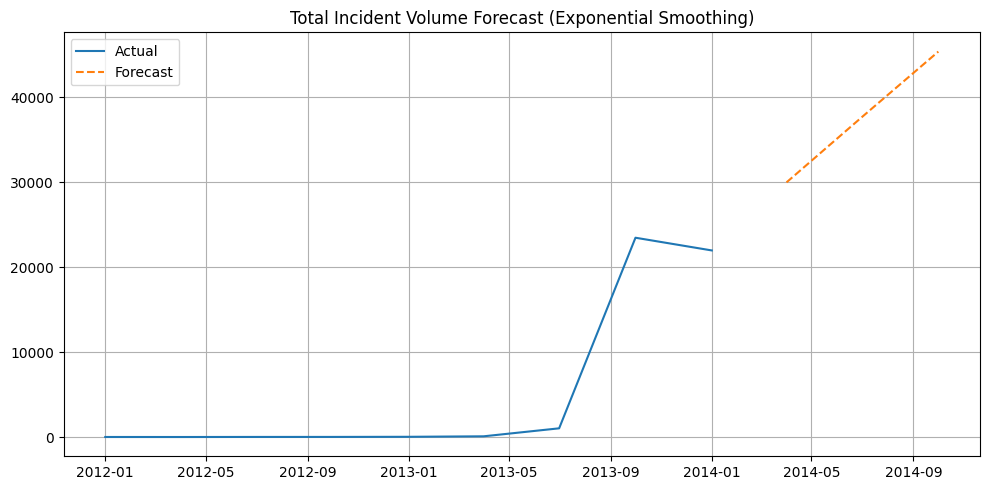

In [413]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(ts, label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title("Total Incident Volume Forecast (Exponential Smoothing)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [414]:
forecast

2014-04-01    29995.642259
2014-07-01    37699.624693
2014-10-01    45403.607127
Freq: QS-OCT, dtype: float64

#### Forecast volume for each category

In [415]:
for i, forecast_value in enumerate(forecast):
    forecast_value = int(forecast_value)  # ensure numeric
    cat_forecast = (category_share * forecast_value).round().astype(int)
    print(f"Forecast for {forecast.index[i]}:\n{cat_forecast}\n")

Forecast for 2014-04-01 00:00:00:
ci_cat
Phone                       1
application             21245
applicationcomponent        3
computer                 2345
database                  138
displaydevice             136
hardware                  284
networkcomponents          69
officeelectronics          98
software                  214
storage                   452
subapplication           5008
Name: incident_count, dtype: int32

Forecast for 2014-07-01 00:00:00:
ci_cat
Phone                       2
application             26702
applicationcomponent        4
computer                 2947
database                  173
displaydevice             171
hardware                  358
networkcomponents          87
officeelectronics         123
software                  269
storage                   569
subapplication           6295
Name: incident_count, dtype: int32

Forecast for 2014-10-01 00:00:00:
ci_cat
Phone                       2
application             32159
applicationcomponent     

#### Conclusion
1. After grouping the number of records reduced to 42 rows
2. Training model on such less data dosent yield good model
3. Followed the above mentioned approach to come to a resonable comclusion.
5. After 2013Q3 the number of incidents has increased rapidly. From 10s to 1000s. There could be a major update that failed, Something changed fundamentally in the data collection, process, or business
6. As the graph suggests, the forecast is linearly increasing, since the data is too less


## Task 4
Predict RFC (Request for change) and possible failure / misconfiguration of ITSM assets.

* The data has only one entry for "request for change category".
* sub-categories has list of all possible failure categories, potentialy having RFC, misconfigured elements such as H/W devices (RFC), NonStop Harddisk (misconfig);..
* From the doubt clearance call, confirmend that with only one record as "request for change", I cannot proceed for modeling; and for sub-categories I can identify potential RFC and misconfig. Proceeding with this method.
* Comparing category and cat-subcat columns to decide the classifier.
* Using cat--subcat classification. It’s richer, more accurate, and better reflects the true complexity of the system.

In [416]:
import pickle

In [417]:
data_enc3 = pd.read_pickle('data.pkl')

In [418]:
data_enc3[data_enc3.category == 'request for change']

,ci_name,ci_cat,ci_subcat,wbs,status,priority,number_cnt,category,kb_number,no_of_reassignments,open_time,resolved_time,close_time,closure_code,no_of_related_interactions,handle_time_hrs,cat-subcat
24520,SBA000759,application,Server Based Application,WBS000296,Closed,5,0.900155,request for change,KM0001032,0,2013-12-31 11:53:00,2014-01-07 14:46:00,2014-01-07 14:46:00,Software,1,170.883333,application--Server Based Application


In [419]:
data_enc3.ci_subcat.unique()

array(['Web Based Application', 'Desktop Application',
       'Server Based Application', 'SAP', 'Client Based Application',
       'Citrix', 'Standard Application', 'Windows Server', 'Laptop',
       'Linux Server', 'Monitor', 'Automation Software', 'SAN',
       'Banking Device', 'Desktop', 'Database', 'Oracle Server',
       'Keyboard', 'Printer', 'Exchange', 'System Software', 'VDI',
       'Encryption', 'Omgeving', 'MigratieDummy', 'Scanner', 'Controller',
       'DataCenterEquipment', 'KVM Switches', 'Switch',
       'Database Software', 'Network Component', 'Unix Server', 'Lines',
       'ESX Cluster', 'zOS Server', 'SharePoint Farm', 'NonStop Server',
       'Application Server', 'Security Software', 'Thin Client',
       'zOS Cluster', 'Router', 'VMWare', 'Net Device', 'Neoview Server',
       'MQ Queue Manager', 'UPS', 'Number', 'Iptelephony',
       'Windows Server in extern beheer', 'Modem', 'X86 Server',
       'ESX Server', 'Virtual Tape Server', 'IPtelephony',
       'No

In [420]:
data_enc3['cat-subcat'].unique()

array(['subapplication--Web Based Application',
       'application--Web Based Application',
       'application--Desktop Application',
       'application--Server Based Application', 'application--SAP',
       'application--Client Based Application', 'subapplication--Citrix',
       'application--Standard Application', 'computer--Windows Server',
       'subapplication--Server Based Application', 'computer--Laptop',
       'computer--Linux Server', 'displaydevice--Monitor',
       'software--Automation Software', 'storage--SAN',
       'application--Citrix', 'computer--Banking Device',
       'computer--Desktop', 'database--Database',
       'computer--Oracle Server', 'hardware--Keyboard',
       'officeelectronics--Printer', 'application--Exchange',
       'software--System Software', 'computer--VDI',
       'hardware--Encryption', 'computer--Omgeving',
       'hardware--MigratieDummy', 'officeelectronics--Scanner',
       'storage--Controller', 'hardware--DataCenterEquipment',
     

#### Comparing subcaty and cat-subcat columns

* cat--subcat gives you richer granularity with meaningful split across all 4 classes.
* category-only collapses most records into RFC or Neither — very coarse labeling.
* category completely misses the nuance in joint/misconfigured cases (Both is near-zero).
* cat--subcat captures fine-grained edge cases, which is critical in misconfig detection.
* More balanced label distribution = better training data = more robust predictions.

Using cat-subcat for RFC and misconfig classification

In [421]:
def classify(row):
    
        is_rfc = False
        is_misconfig = False

        # RFC logic
        if row['ci_cat'] in ['application', 'software', 'database', 'applicationcomponent']:
            is_rfc = True
        if row['ci_subcat'] in ['Firewall', 'Router', 'Switch', 'Protocol', 'Storage', 'Cluster']:
            is_rfc = True
        if 'Server' in row['ci_subcat'] or 'Service' in row['ci_subcat']:
            is_rfc = True

        # Misconfig logic
        if row['ci_cat'] in ['networkcomponents', 'software', 'database', 'applicationcomponent']:
            is_misconfig = True
        if row['ci_subcat'] in ['Firewall', 'Router', 'Switch', 'Protocol', 'Security Software']:
            is_misconfig = True
        if 'Server' in row['ci_subcat'] or 'Cluster' in row['ci_subcat']:
            is_misconfig = True

        # Final classification
        if is_rfc and is_misconfig:
            return 'Both'  # Both
        elif is_misconfig:
            return 'Misconfig'  # Misconfig only
        elif is_rfc:
            return 'RFC'  # RFC only
        else:
            return 'Neither'  # Neither

In [422]:
data_enc3['config_flag'] = data_enc3.apply(classify, axis=1)

In [423]:
data_enc3.config_flag.isna().sum()

0

In [424]:
data_enc3.config_flag.value_counts(normalize=True)

config_flag
Both         0.424216
RFC          0.330902
Neither      0.242909
Misconfig    0.001974
Name: proportion, dtype: float64

In [425]:
data_enc3.category.unique()

array(['incident', 'request for information', 'complaint',
       'request for change'], dtype=object)

In [426]:
def classify_top_category(cat):
    is_rfc = cat in ['application', 'software', 'database', 'storage', 'applicationcomponent']
    is_misconfig = cat in ['software', 'database', 'networkcomponents', 'applicationcomponent']

    if is_rfc and is_misconfig:
        return "both"  # Both
    elif is_misconfig:
        return "misconfig"  # Misconfig
    elif is_rfc:
        return "RCF"  # RFC
    else:
        return "neither"  # Neither

In [427]:
data_enc3['config_flag2'] = data_enc3['ci_cat'].apply(classify_top_category)


In [428]:
data_enc3.config_flag2.value_counts(normalize=True)

config_flag2
RCF          0.723383
neither      0.262477
both         0.011844
misconfig    0.002296
Name: proportion, dtype: float64

In [429]:
data_enc3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ci_name                     46606 non-null  object        
 1   ci_cat                      46606 non-null  object        
 2   ci_subcat                   46606 non-null  object        
 3   wbs                         46606 non-null  object        
 4   status                      46606 non-null  object        
 5   priority                    46606 non-null  object        
 6   number_cnt                  46606 non-null  float64       
 7   category                    46606 non-null  object        
 8   kb_number                   46606 non-null  object        
 9   no_of_reassignments         46606 non-null  int64         
 10  open_time                   46606 non-null  datetime64[ns]
 11  resolved_time               46606 non-null  datetime64

#### Preprocessing 

In [430]:
def frequency_encode(data, column):
    freq = data[column].value_counts()
    data[column + '_freq'] = data[column].map(freq)
    return data

data_enc3 = frequency_encode(data_enc3, 'ci_name')
data_enc3 = frequency_encode(data_enc3, 'wbs')
data_enc3 = frequency_encode(data_enc3, 'kb_number')
data_enc3 = frequency_encode(data_enc3, 'ci_cat')
data_enc3 = frequency_encode(data_enc3, 'ci_subcat')

one_hot_cols = ['status', 'category', 'closure_code', 'no_of_related_interactions'] #, 'cat-subcat']
# removing cat-subcat column since our target is engineered from this column
data_enc3 = pd.get_dummies(data_enc3,columns=one_hot_cols)

date_cols = ['open_time', 'resolved_time', 'close_time']

for col in date_cols:
    data_enc3[f'{col}_year'] = data_enc3[col].dt.year
    data_enc3[f'{col}_month'] = data_enc3[col].dt.month
    data_enc3[f'{col}_day'] = data_enc3[col].dt.day
    data_enc3[f'{col}_weekday'] = data_enc3[col].dt.weekday
    data_enc3[f'{col}_hour'] = data_enc3[col].dt.hour

In [431]:
data_enc3.drop(date_cols + ['ci_name', 'wbs', 'kb_number','config_flag2', 'cat-subcat', 'ci_cat', 'ci_subcat'], axis=1, inplace=True, errors='ignore')

In [432]:
data_enc3['priority'] = pd.to_numeric(data_enc3.priority)

In [433]:
data_enc3.head(3)

,priority,number_cnt,no_of_reassignments,handle_time_hrs,config_flag,ci_name_freq,wbs_freq,kb_number_freq,ci_cat_freq,ci_subcat_freq,status_Closed,status_Work in progress,category_complaint,category_incident,category_request for change,category_request for information,closure_code_Data,closure_code_Hardware,closure_code_Inquiry,closure_code_Kwaliteit van de output,closure_code_No error - works as designed,closure_code_Operator error,closure_code_Other,closure_code_Overig,closure_code_Questions,closure_code_Referred,closure_code_Software,closure_code_Unknown,closure_code_User error,closure_code_User manual not used,no_of_related_interactions_0,no_of_related_interactions_1,no_of_related_interactions_2,no_of_related_interactions_3,no_of_related_interactions_4,no_of_related_interactions_5,no_of_related_interactions_6,no_of_related_interactions_7,no_of_related_interactions_8,no_of_related_interactions_9,no_of_related_interactions_10,no_of_related_interactions_11,no_of_related_interactions_12,no_of_related_interactions_13,no_of_related_interactions_14,no_of_related_interactions_15,no_of_related_interactions_16,no_of_related_interactions_17,no_of_related_interactions_18,no_of_related_interactions_19,no_of_related_interactions_20,no_of_related_interactions_21,no_of_related_interactions_22,no_of_related_interactions_23,no_of_related_interactions_24,no_of_related_interactions_25,no_of_related_interactions_26,no_of_related_interactions_27,no_of_related_interactions_28,no_of_related_interactions_29,no_of_related_interactions_30,no_of_related_interactions_31,no_of_related_interactions_33,no_of_related_interactions_34,no_of_related_interactions_37,no_of_related_interactions_39,no_of_related_interactions_40,no_of_related_interactions_41,no_of_related_interactions_42,no_of_related_interactions_43,no_of_related_interactions_44,no_of_related_interactions_45,no_of_related_interactions_54,no_of_related_interactions_55,no_of_related_interactions_57,no_of_related_interactions_74,no_of_related_interactions_88,no_of_related_interactions_118,no_of_related_interactions_288,no_of_related_interactions_370,open_time_year,open_time_month,open_time_day,open_time_weekday,open_time_hour,resolved_time_year,resolved_time_month,resolved_time_day,resolved_time_weekday,resolved_time_hour,close_time_year,close_time_month,close_time_day,close_time_weekday,close_time_hour
0,4,0.601292,26,15312.316667,Neither,309,495,292,7782,15311,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012,2,5,6,13,2013,11,4,0,13,2013,11,4,0,13
1,3,0.415050,33,15116.866667,RFC,615,619,452,33011,15311,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012,3,12,0,15,2013,12,2,0,12,2013,12,2,0,12
2,3,0.517551,3,15722.616667,RFC,119,784,1,33011,3876,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012,3,29,3,12,2014,1,13,0,15,2014,1,13,0,15


In [434]:
data_enc3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 95 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   priority                                   46606 non-null  int64  
 1   number_cnt                                 46606 non-null  float64
 2   no_of_reassignments                        46606 non-null  int64  
 3   handle_time_hrs                            46606 non-null  float64
 4   config_flag                                46606 non-null  object 
 5   ci_name_freq                               46606 non-null  int64  
 6   wbs_freq                                   46606 non-null  int64  
 7   kb_number_freq                             46606 non-null  int64  
 8   ci_cat_freq                                46606 non-null  int64  
 9   ci_subcat_freq                             46606 non-null  int64  
 10  status_Closed         

In [435]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

target_enc = LabelEncoder()
y = target_enc.fit_transform(data_enc3.config_flag)
x = data_enc3.drop('config_flag', axis=1)

In [436]:
x.columns

Index(['priority', 'number_cnt', 'no_of_reassignments', 'handle_time_hrs',
       'ci_name_freq', 'wbs_freq', 'kb_number_freq', 'ci_cat_freq',
       'ci_subcat_freq', 'status_Closed', 'status_Work in progress',
       'category_complaint', 'category_incident',
       'category_request for change', 'category_request for information',
       'closure_code_Data', 'closure_code_Hardware', 'closure_code_Inquiry',
       'closure_code_Kwaliteit van de output',
       'closure_code_No error - works as designed',
       'closure_code_Operator error', 'closure_code_Other',
       'closure_code_Overig', 'closure_code_Questions',
       'closure_code_Referred', 'closure_code_Software',
       'closure_code_Unknown', 'closure_code_User error',
       'closure_code_User manual not used', 'no_of_related_interactions_0',
       'no_of_related_interactions_1', 'no_of_related_interactions_2',
       'no_of_related_interactions_3', 'no_of_related_interactions_4',
       'no_of_related_interactions_5', 

In [437]:
from sklearn.preprocessing import minmax_scale
x = pd.DataFrame(minmax_scale(x), columns=x.columns)

In [438]:
x_train,x_test, y_train,y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=2, stratify=y)

#### Model training

In [439]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [440]:
import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [441]:
from collections import Counter

In [442]:
config_flag_dic = dict(Counter(y_train))

In [471]:
models = {
    "DecisionTreeClassifier" : {'model':[DecisionTreeClassifier(random_state=2,class_weight=config_flag_dic)]},
    "RandomForestClassifier" : {'model':[RandomForestClassifier(random_state=2, class_weight=config_flag_dic)]},
    "xgb" : {'model' : [xgb.XGBClassifier(random_state=2)]},
    "KNeighborsClassifier" : {'model' : [KNeighborsClassifier()]},
    "MultinomialNB" : {'model' : [MultinomialNB()]},
    "LinearSVC" : {'model' :[LinearSVC(random_state=2)]},
    "LogisticRegression" : {'model' : [LogisticRegression(random_state=2)]},
    "ExtraTreesClassifier" : {'model' : [ExtraTreesClassifier(random_state=2,class_weight=config_flag_dic)]},
    "AdaBoostClassifier" : {'model' : [AdaBoostClassifier(random_state=2)]},
    "BaggingClassifier" : {'model' : [BaggingClassifier(random_state=2)]},
    "MultinomialNB" : {'model' : [MultinomialNB()]},
    # "SVC" : {'model' : [SVC(random_state=2)]}, # Takes long time to train - train f1[0.75, 0.99]	test f1[0.74, 0.99] 
}

In [472]:
pipe = Pipeline([("model", DummyClassifier())])

In [473]:
from itertools import cycle

Fitting 2 folds for each of 1 candidates, totalling 2 fits
DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3955
           1       0.71      0.83      0.77        18
           2       1.00      1.00      1.00      2264
           3       1.00      1.00      1.00      3085

    accuracy                           1.00      9322
   macro avg       0.93      0.96      0.94      9322
weighted avg       1.00      1.00      1.00      9322



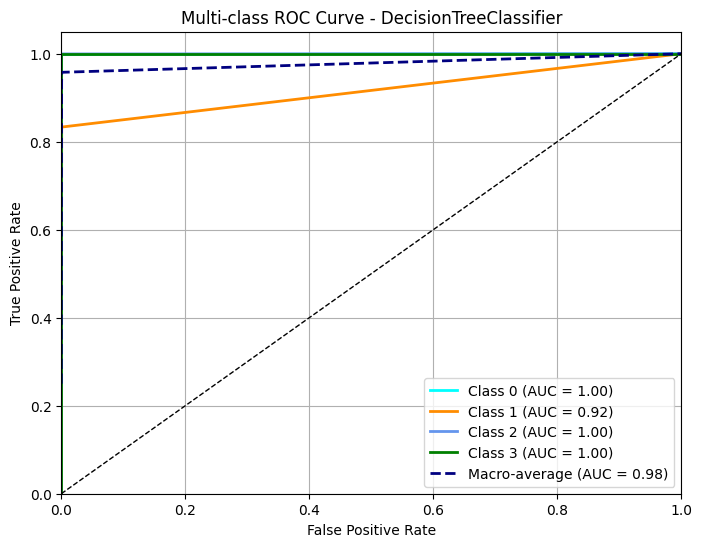


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3955
           1       0.20      0.06      0.09        18
           2       0.99      1.00      1.00      2264
           3       1.00      1.00      1.00      3085

    accuracy                           1.00      9322
   macro avg       0.80      0.76      0.77      9322
weighted avg       1.00      1.00      1.00      9322



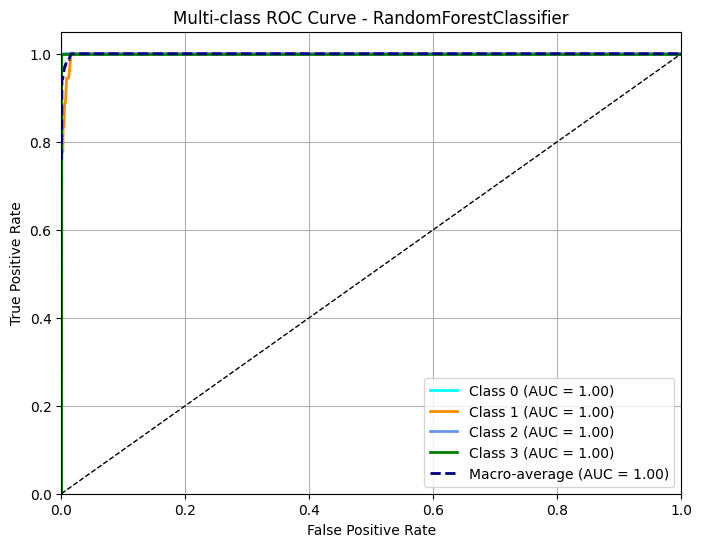


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
xgb
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3955
           1       1.00      0.94      0.97        18
           2       1.00      1.00      1.00      2264
           3       1.00      1.00      1.00      3085

    accuracy                           1.00      9322
   macro avg       1.00      0.99      0.99      9322
weighted avg       1.00      1.00      1.00      9322



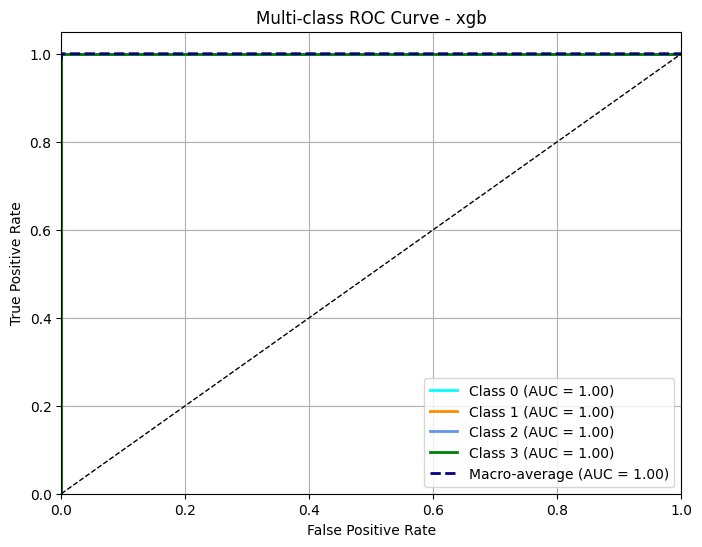


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3955
           1       0.09      0.06      0.07        18
           2       0.94      0.96      0.95      2264
           3       0.90      0.84      0.87      3085

    accuracy                           0.89      9322
   macro avg       0.70      0.69      0.69      9322
weighted avg       0.89      0.89      0.89      9322



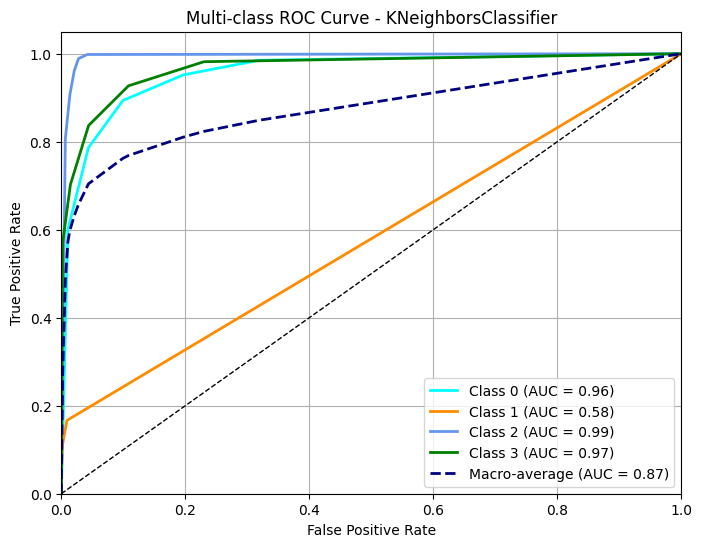


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
MultinomialNB
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      3955
           1       0.00      0.00      0.00        18
           2       0.87      0.69      0.77      2264
           3       0.59      0.58      0.59      3085

    accuracy                           0.67      9322
   macro avg       0.53      0.50      0.51      9322
weighted avg       0.68      0.67      0.67      9322



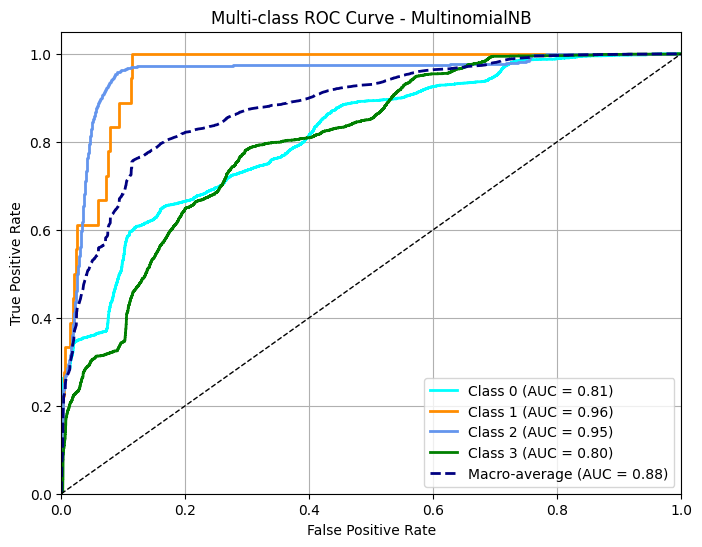


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
LinearSVC
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3955
           1       0.00      0.00      0.00        18
           2       0.91      0.98      0.94      2264
           3       1.00      1.00      1.00      3085

    accuracy                           0.97      9322
   macro avg       0.72      0.73      0.73      9322
weighted avg       0.97      0.97      0.97      9322

⚠️ Skipping ROC-AUC for LinearSVC: No predict_proba

--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
LogisticRegression
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3955
           1       0.00      0.00      0.00        18
           2       0.91      0.97    

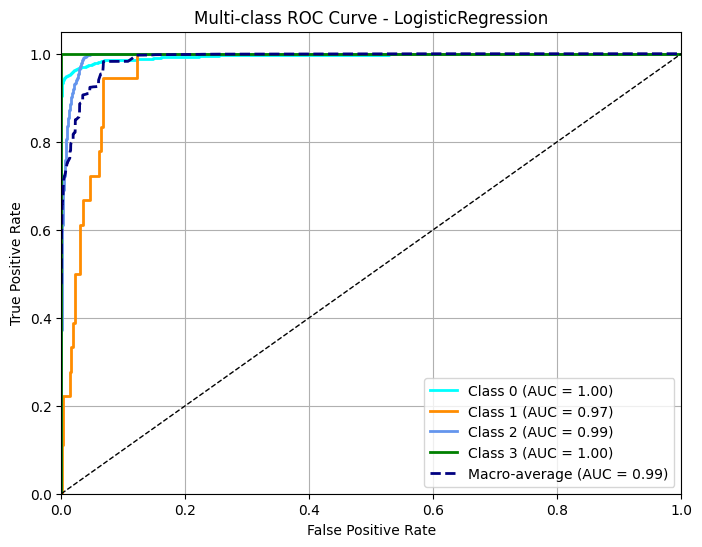


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
ExtraTreesClassifier
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3955
           1       0.67      0.11      0.19        18
           2       0.98      1.00      0.99      2264
           3       1.00      1.00      1.00      3085

    accuracy                           0.99      9322
   macro avg       0.91      0.77      0.79      9322
weighted avg       0.99      0.99      0.99      9322



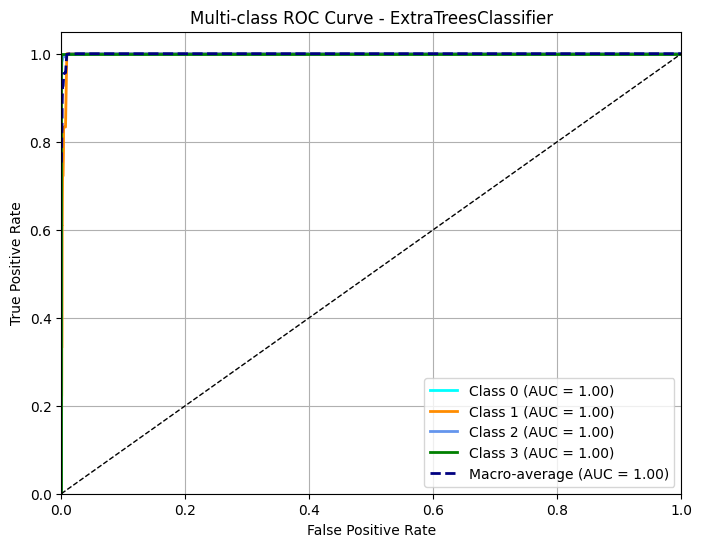


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3955
           1       0.52      0.61      0.56        18
           2       0.98      0.98      0.98      2264
           3       1.00      1.00      1.00      3085

    accuracy                           0.99      9322
   macro avg       0.87      0.90      0.88      9322
weighted avg       0.99      0.99      0.99      9322



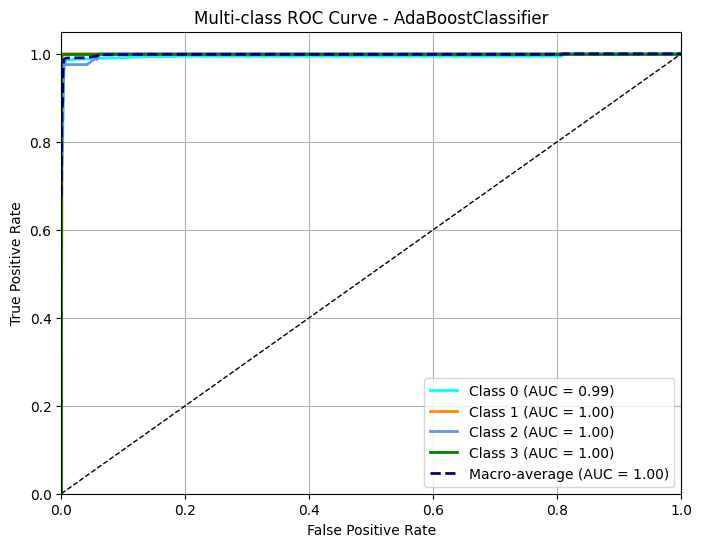


--------------------------------------------------------------------------------

Fitting 2 folds for each of 1 candidates, totalling 2 fits
BaggingClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3955
           1       0.94      0.94      0.94        18
           2       1.00      1.00      1.00      2264
           3       1.00      1.00      1.00      3085

    accuracy                           1.00      9322
   macro avg       0.99      0.99      0.99      9322
weighted avg       1.00      1.00      1.00      9322



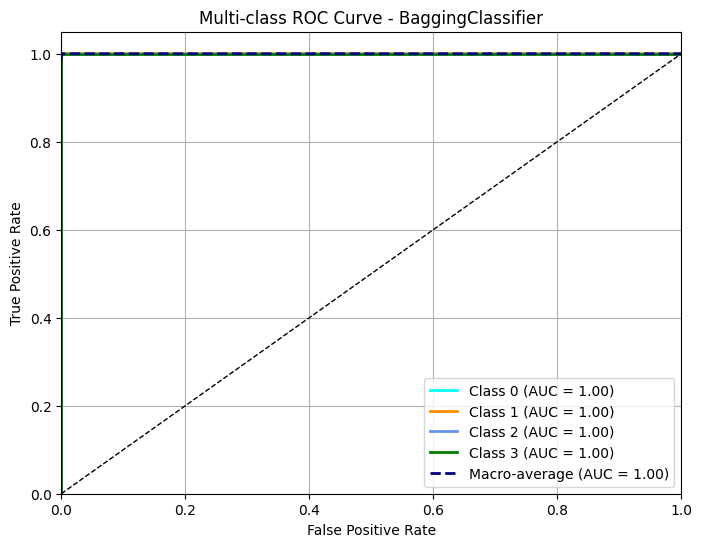


--------------------------------------------------------------------------------



In [476]:
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

result = []
for model_name, model_params in models.items():
    gcv = GridSearchCV(estimator=pipe, param_grid=model_params, scoring="f1_micro", cv=2, verbose=1)
    gcv.fit(x_train, y_train)

    pred_train = gcv.predict(x_train,)
    pred_test = gcv.predict(x_test)

    f1_train = f1_score(y_train, pred_train, average='micro')
    f1_test = f1_score(y_test, pred_test, average='micro')

    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    
    time = gcv.refit_time_
    result.append({
        'model_name': model_name,
        'time' : time,
        'f1_train' : f1_train,
        'f1_test' : f1_test,
        'accuracy_train':accuracy_train,
        'accuracy_test':accuracy_test
    })
    print(model_name)
    print(classification_report(y_test, pred_test))


    if hasattr(gcv.best_estimator_['model'], "predict_proba"):
        y_score = gcv.predict_proba(x_test)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["macro"], tpr["macro"] = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])), []
        mean_tpr = np.zeros_like(fpr["macro"])

        for i in range(n_classes):
            mean_tpr += np.interp(fpr["macro"], fpr[i], tpr[i])
        mean_tpr /= n_classes
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.figure(figsize=(8, 6))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

        plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--',
                 label=f'Macro-average (AUC = {roc_auc["macro"]:0.2f})', linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multi-class ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
    else:
        print(f"⚠️ Skipping ROC-AUC for {model_name}: No predict_proba")

    print("\n" + "-"*80 + "\n")

    

In [477]:
result_df = pd.DataFrame(result)

In [478]:
result_df['f1_diff'] = result_df['f1_train'] - result_df['f1_test']

In [479]:
result_df.sort_values(by=['f1_diff', 'f1_test'], ascending=[True, False])

,model_name,time,f1_train,f1_test,accuracy_train,accuracy_test,f1_diff
2,xgb,1.124254,1.000000,0.999785,1.000000,0.999785,0.000215
4,MultinomialNB,0.018004,0.673560,0.673246,0.673560,0.673246,0.000314
9,BaggingClassifier,0.721162,1.000000,0.999678,1.000000,0.999678,0.000322
8,AdaBoostClassifier,3.393769,0.990639,0.990131,0.990639,0.990131,0.000509
0,DecisionTreeClassifier,0.107021,1.000000,0.998820,1.000000,0.998820,0.001180
6,LogisticRegression,2.012455,0.971838,0.969964,0.971838,0.969964,0.001874
5,LinearSVC,2.685608,0.971945,0.969964,0.971945,0.969964,0.001982
1,RandomForestClassifier,3.616819,1.000000,0.996782,1.000000,0.996782,0.003218
7,ExtraTreesClassifier,4.096946,1.000000,0.993349,1.000000,0.993349,0.006651
3,KNeighborsClassifier,0.016004,0.930614,0.892191,0.930614,0.892191,0.038423


#### Conclusion

1. Most models learn and predict accurately.
2. MultinomialNB has the least learning rate.
3. Most models dosent predict well for class 1
4. XGB & BaggingClassifier are the best considering all the classes prediction